## Interactive POI Visualization in Python with OpenStreetMap Data

In [ ]:
# %pip install osmnx
# %pip install matplotlib
# %pip install folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
import osmnx as ox 
import geopandas as gpd 
import folium 
print(ox.__version__)

2.0.6


<Axes: >

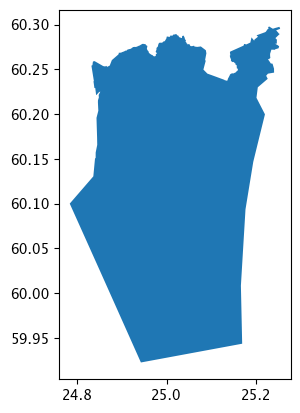

In [4]:
city_name = 'Helsinki'
admin = ox.geocode_to_gdf(city_name)
admin.plot()

In [5]:
pubs = ox.features_from_place(city_name, {'amenity': 'pub'})
sports = ox.features_from_place(city_name, {'leisure': ['gym', 'sports_centre']})
healthcare = ox.features_from_place(city_name, {'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']})

In [ ]:
# prints counts

print('Pubs:', len(pubs), ' | Sports:', len(sports), ' | Healthcare:', len(healthcare))

Pubs: 243  | Sports: 165  | Healthcare: 177


In [8]:
def to_points(gdf):
    if gdf.empty:
        return gdf
    return gdf.to_crs(3857).centroid.to_crs(4326).to_frame('geometry')

In [9]:
pubs = to_points(pubs)
sports = to_points(sports)
healthcare = to_points(healthcare)
minx, miny, maxx, maxy = admin.total_bounds
fit_bounds = [[miny, minx], [maxy, maxx]]
center = [(miny + maxy) / 2, (minx + maxx) / 2]

In [10]:
m = folium.Map(
    location=center,
    tiles='CartoDB dark_matter',
    control_scale=True
)
m

In [11]:
admin_layer = folium.FeatureGroup(name='Admin Boundary', show=True)
folium.GeoJson(
    admin,
    style_function=lambda feature: {
        'fillColor': '#ffffff',
        'color': '#ffffff',
        'weight': 3,
        'fillOpacity': 0.15
    }
).add_to(admin_layer)
admin_layer.add_to(m)
folium.LayerControl(collapsed=False, position='topright').add_to(m)
if fit_bounds:
    m.fit_bounds(fit_bounds)
m

In [12]:
admin_layer = folium.FeatureGroup(name='Admin Boundary', show=True)
pubs_layer = folium.FeatureGroup(name='Pubs', show=True)
sports_layer = folium.FeatureGroup(name='Gyms & Sports', show=True)
health_layer = folium.FeatureGroup(name='Healthcare', show=False)
folium.GeoJson(
    admin,
    style_function=lambda feature: {
        'fillColor': '#ffffff',
        'color': '#ffffff',
        'weight': 3,
        'fillOpacity': 0.15
    }
).add_to(admin_layer)
def add_points(gdf, feature_group, color):
    if gdf is not None and not gdf.empty:
        for _, row in gdf.iterrows():
            geom = row.geometry
            if geom is None:
                continue
            lat, lon = geom.y, geom.x
            folium.CircleMarker(
                location=[lat, lon],
                radius=2,
                weight=0.5,
                fill=True,
                fill_opacity=0.8,
                color=color,
                fill_color=color,
                # tooltip removed as requested
            ).add_to(feature_group)
add_points(pubs, pubs_layer, '#ff9933')     # orange
add_points(sports, sports_layer, '#44e0ff') # cyan
add_points(healthcare, health_layer, '#ff4444') # red
admin_layer.add_to(m)
pubs_layer.add_to(m)
sports_layer.add_to(m)
health_layer.add_to(m)
folium.LayerControl(collapsed=False, position='topright').add_to(m)
if fit_bounds:
    m.fit_bounds(fit_bounds)
m.save('helsiniki_pubs.html')
m